This Notebook contains my experiments with training Neural Cellular Automata, NCA, for image editing and style transfer using the CLIP model by OpenAI. This is an early prototype and as a result, the code is a bit messy, uncommented and there are many more things to try to optimize and improve this method and code. 

I would like to thank the following people for their ideas and code that has been instrumental in making this work!

I would like to thank Alexander Mordvintsev, Ettore Randazzo, Eyvind Niklasson, Michael Levin (hopefully I did not miss anyone) for coming up with NCAs and for providing the code that forms the backbone of this notebook. If you see messy code, it is likely something I added. Since most of the code stems from them, I added their license. For more on NCAs check out their wonderful distill publications on the topic. https://distill.pub/2020/selforg/

I would also like to thank Katherine Crowson since the CLIP guidance code as well as the content loss code stems from her implementation of "A Neural Algorithm of Artistic Style" Gatys et al. (2015)

Lastly, I would like to thank John Whitaker (https://twitter.com/JohnowhitakerA) whom I saw use CLIP to guide texture synthesis in NCAs and therefore inspired this work.

By Magnus Petersen \\
https://twitter.com/Omorfiamorphism \\
magnuspetersen@live.de 

Original license: \\
Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#@title Imports and Notebook Utilities
%%capture
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import cv2
import sys
import numbers
import math
from functools import partial

!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
sys.path.append('./CLIP')

import clip

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

import torch
from torch import nn
from torch.nn import functional as F
import torchvision.models as models
from torchvision import transforms

torch.set_default_tensor_type('torch.cuda.FloatTensor')

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

def loss_plot():
  if len(style_log) > 0:
    fig, ax = pl.subplots(4, 1, figsize=(9, 7), constrained_layout=True)
    fig.tight_layout()
    ax[0].plot(step, style_log, 'r.', alpha=1) 
    ax[0].set_yscale('log')
    ax[0].title.set_text('Style Loss')
    ax[0].yaxis.tick_right()

    ax[1].plot(step, content_log, 'b.', alpha=1)
    ax[1].set_yscale('log')
    ax[1].title.set_text('Content Loss')
    ax[1].yaxis.tick_right()

    ax[2].plot(step, overflow_log, 'k.', alpha=1) 
    ax[2].set_yscale('log')
    ax[2].title.set_text('Overflow Loss')
    ax[2].yaxis.tick_right()

    ax[3].plot(step, ae_log, 'k.', alpha=1) 
    ax[3].set_yscale('log')
    ax[3].title.set_text('Ava Loss')
    ax[3].yaxis.tick_right()

    pl.show()
    
def create_video(path_or_url = "https://uploads3.wikiart.org/images/federico-zandomeneghi/lady-with-a-hat-1895.jpg", image_length = 512, frames = 200, steps_per_frame = 1, end_speed_up = 6, channel = 3):
  with VideoWriter() as vid, torch.no_grad():
    x = ca.sample(path_or_url, sz=image_length)
    img = (x[0][...,channel:(channel+3),:,:]+0.5).permute(1, 2, 0).cpu()
    vid.add(zoom(img, 1))
    for k in tnrange(frames, leave=False):
      step_n = max(int(end_speed_up*k/frames), steps_per_frame)
      for i in range(step_n):
        x[::, 3:] = ca(x)
      img = (x[0][...,channel:(channel+3),:,:]+0.5).permute(1, 2, 0).cpu()
      vid.add(zoom(img, 1))
  
!nvidia-smi -L

In [2]:
#@title Losses and CLIP related functions
def gram_calculation(x, layers):
  grams = []
  for i, layer in enumerate(vgg19[:max(layers)+1]):
    x = layer(x)
    if i in layers:
      h, w = x.shape[-2:]
      y = x.clone()  # workaround for pytorch in-place modification bug(?)
      gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
      grams.append(gram)
  return grams

def tv_loss(x):
  input = F.pad(x, (0, 1, 0, 1), 'replicate')
  x_diff = input[:,:, :-1, 1:] - input[:,:, :-1, :-1]
  y_diff = input[:,:, 1:, :-1] - input[:,:, :-1, :-1]
  return (x_diff**2 + y_diff**2).mean()

def transfer_loss(grams_x, grams_y):
  loss = 0.0
  for x, y in zip(grams_x, grams_y):
    loss = loss + (x-y).square().mean()
  return loss

def overflow_loss(x):
  return (x-x.clamp(-1.0, 1.0)).abs().sum()

def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

In [3]:
#@title Neural CA
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)

sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
  y = torch.nn.functional.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

class CA(torch.nn.Module):
  def __init__(self, chn=18, hidden_n=90, blur_kernel=[3, 7, 15]):
    super().__init__()
    self.chn = chn
    self.w1 = torch.nn.Conv2d(chn*4, hidden_n, 1)
    self.w2 = torch.nn.Conv2d(hidden_n, hidden_n, 1)
    self.w3 = torch.nn.Conv2d(hidden_n, chn-3, 1)

    self.blur_layers = nn.ModuleList()
    self.pad_size = []
    for i in blur_kernel:
      self.blur_layers.append(GaussianSmoothing(1, kernel_size=i, sigma=2))
      self.pad_size.append(int((i-1)/2))

    gain = 0.1
    self.w1.weight.data = self.w1.weight.data*gain
    self.w1.bias.data = self.w1.bias.data*gain
    self.w2.weight.data = self.w2.weight.data*gain
    self.w2.bias.data = self.w2.bias.data*gain
    self.w3.weight.data = self.w3.weight.data*gain
    self.w3.bias.data = self.w3.bias.data*gain

  def forward(self, x):
    filters = torch.stack([sobel_x, sobel_x.T, lap])
    y = perchannel_conv(x, filters)
    y = torch.concat((x, y), 1)
    y = torch.relu(self.w1(y))
    y = torch.relu(self.w2(y))
    y = self.w3(y)

    b, c, h, w = y.shape

    for i in range(len(self.pad_size)):
      p_sz = self.pad_size[i]
      pad_blur = F.pad(x[::, -(i+2)][::, None], (p_sz, p_sz, p_sz, p_sz), mode='circular')
      x[::, -(i+2):-(i+1)] = self.blur_layers[i](pad_blur)

    return x[::, 3:]+y

  def seed(self, n, sz=224):
    m = len(images)
    if n >= m:
      n = m
    start = torch.rand(n, self.chn, sz, sz)    
    idx = np.random.choice(len(images), n, replace=False)
    image_seed = images[idx].permute(0, 3, 1, 2)
    targets = target_encoding[idx]
    start[::, :3, ::, ::] = image_seed
    start[::, 3:6, ::, ::] = image_seed
    start -= 0.5 
    return start, targets

  def sample(self, image_url, sz=224):
    image = imread(image_url, max_size=sz)
    image_seed = to_nchw(image)
    start = torch.rand(1, self.chn, image_seed.shape[2], image_seed.shape[3])

    start[::, :3, ::, ::] = image_seed
    start[::, 3:6, ::, ::] = image_seed
    start -= 0.5 
    return start

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

def run_n(x):
  x[::, 3:] = ca(x)
  return x

def to_rgb(x, idx):
  return x[...,idx:(idx+3),:,:]+0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 16125


In [7]:
#@title Select Training Dataset {vertical-output: true}

dropdown = 'art' #@param ["art", "pictures", "mixed"]

if dropdown == "art":
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18BrSN1ZqoRQBlcuU6f77M5VCQ2IrqS-x' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18BrSN1ZqoRQBlcuU6f77M5VCQ2IrqS-x" -O art_224.pt && rm -rf /tmp/cookies.txt
if dropdown == "pictures":
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1njF5STaYrnlziFYfKLa8Bcb5VjkGixXj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1njF5STaYrnlziFYfKLa8Bcb5VjkGixXj" -O pictures_224.pt && rm -rf /tmp/cookies.txt
if dropdown == "mixed":
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19m4_uOTbMCowhvLNhY_GbYIBEMQDuO8y' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19m4_uOTbMCowhvLNhY_GbYIBEMQDuO8y" -O mixed_224.pt && rm -rf /tmp/cookies.txt
clear_output()

vgg19 = models.vgg19(pretrained=True).features[:23]
normalize_vgg = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

images = torch.load("/content/"+dropdown+"_224.pt")

with torch.no_grad():
  target_encoding = torch.zeros(size = (images.shape[0], 512, 512))
  for i in range(images.shape[0]):
    target_encoding[i] = gram_calculation(normalize_vgg(images[i].float().permute([2, 0, 1])[None]), [22])[0][0]

In [8]:
#@title Target image {vertical-output: true}

prompts = ['A piece of art made out of mosaic', 'A colorful mosaic']
image_prompts = []

style_w = 100 #Ranges between 30 and 300 have been optimal in the past
content_w = 1
aes_w = 0.5 #aesthetic loss weigth by @rivershavewings 
target_ava = 9.9 #target aestheticness 10 is the maximum 0 the minimum

layers = [22]
pool_size = 400

In [9]:
#@title setup training
cutn = 2
size = 224
side_x = size
side_y = size
n = 4

init_image = None   # This can be an URL or Colab local path and must be in quotes.

clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).cuda()
clip_size = clip_model.visual.input_resolution
make_cutouts = MakeCutouts(clip_size, cutn)
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

target_embeds, weights = [], []

for prompt in prompts:
    txt, weight = parse_prompt(prompt)
    target_embeds.append(clip_model.encode_text(clip.tokenize(txt)).float())
    weights.append(weight)

for prompt in image_prompts:
    path, weight = parse_prompt(prompt)
    img = Image.open(fetch(path)).convert('RGB')
    img = TF.resize(img, min(side_x, side_y, *img.size), transforms.InterpolationMode.LANCZOS)
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0))
    embed = clip_model.encode_image(normalize(batch)).float()
    target_embeds.append(embed)
    weights.extend([weight / cutn] * cutn)

target_embeds = torch.cat(target_embeds)
weights = torch.tensor(weights)
if weights.sum().abs() < 1e-3:
    raise RuntimeError('The weights must not sum to 0.')
weights /= weights.sum().abs()

init = None
if init_image is not None:
    init = Image.open(fetch(init_image)).convert('RGB')
    init = init.resize((side_x, side_y), Image.LANCZOS)
    init = TF.to_tensor(init).unsqueeze(0).mul(2).sub(1)

ca = CA()
opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 2000], 0.3)

with torch.no_grad():
  pool_images, pool_targets = ca.seed(pool_size)

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11jlIc80VPkGJ03W_wHW7fUiVY9GyMAF8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11jlIc80VPkGJ03W_wHW7fUiVY9GyMAF8" -O ava_vit_b_16_linear.pth && rm -rf /tmp/cookies.txt

layer_weights = torch.load("/content/ava_vit_b_16_linear.pth")
ae_reg = nn.Linear(512, 1).cuda()
ae_reg.bias.data = layer_weights["bias"].cuda()
ae_reg.weight.data = layer_weights["weight"].cuda()
target_rating = torch.ones(size = (4, 1))*target_ava

clear_output()

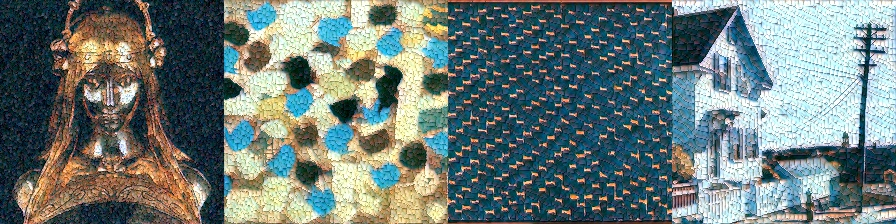

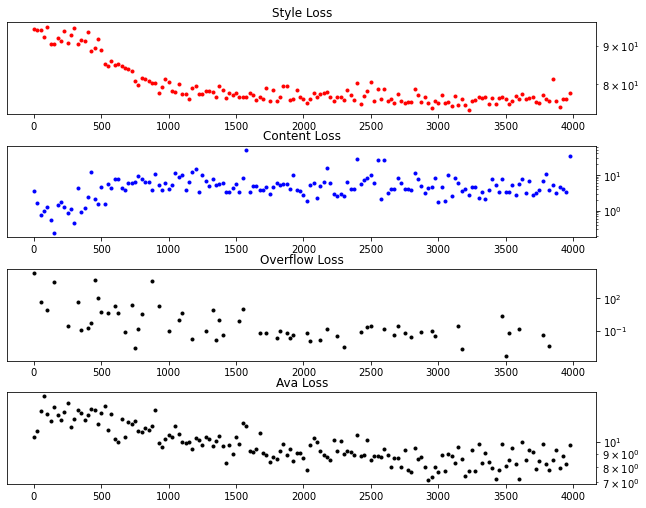

In [10]:
#@title training loop {vertical-output: true}
style_log = []
content_log = []
overflow_log = []
ae_log = []
step = []

for i in range(4000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool_images), 4, replace=False)
    x = pool_images[batch_idx]
    target_content = pool_targets[batch_idx]
    if i%5 == 0:
      x[:1], target_content[:1] = ca.seed(1)
    target_content = [target_content]
  step_n = np.random.randint(32, 96)
  x = torch.utils.checkpoint.checkpoint_sequential([run_n]*step_n, 16, x)
  imgs = to_rgb(x, 3)

  over_loss = overflow_loss(x)
  grams_content = gram_calculation(normalize_vgg(imgs), layers)
  content_loss = transfer_loss(grams_content, target_content)*content_w

  image_embeds = clip_model.encode_image(normalize(imgs.div(2))).float()
  dists = spherical_dist_loss(image_embeds.unsqueeze(1), target_embeds.unsqueeze(0))
  style_loss = dists.view([n, -1]).mul(weights).sum(1).mean([0])*style_w

  aes_rating = ae_reg(F.normalize(image_embeds, dim=-1))
  aes_loss = (aes_rating-target_rating).square().mean()*aes_w

  loss = style_loss+content_loss+over_loss+aes_loss

  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool_images[batch_idx] = x                
    pool_targets[batch_idx] = target_content[0]

    if i%25==0:
      style_log.append(style_loss.item())
      content_log.append(content_loss.item())
      overflow_log.append(over_loss.item())
      ae_log.append(aes_loss.item())
      step.append(i)

      clear_output(True)
      imgs = imgs.permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs))
      loss_plot()
      pl.show()

In [11]:
torch.save(ca, prompts[0]+str(style_w)+".pt")

In [12]:
#@title NCA video {vertical-output: true}

#path_or_url = "https://uploads3.wikiart.org/images/paul-kane/the-buffalo-pound-1849.jpg!Large.jpg"
#path_or_url = "https://uploads3.wikiart.org/images/jean-fouquet/cases-of-noble-men-and-women.jpg!Large.jpg"
#path_or_url = "https://uploads3.wikiart.org/images/ottone-rosai/via-san-leonardo(2).jpg!Large.jpg"
#path_or_url = "https://uploads0.wikiart.org/images/domenico-ghirlandaio/portrait-of-a-girl.jpg"
path_or_url = "https://uploads4.wikiart.org/images/albert-joseph-moore/midsummer-1887.jpg"


create_video(path_or_url = path_or_url, image_length = 1080, frames = 300,
             steps_per_frame = 2, end_speed_up = 3, channel = 3)

Output hidden; open in https://colab.research.google.com to view.